In [1]:
import random
import time
from itertools import product, islice
from collections import defaultdict
from copy import deepcopy
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize

import torch
import torch.nn as nn

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
torch.set_default_dtype(torch.float64)
device

'cuda:0'

In [3]:
def get_func(model: nn.Module, loss_fn, x, y):
    def func(*p_tensors):
        assert len(list(model.parameters())) == len(p_tensors)
        assert type(model) is nn.Sequential
        i = 0
        z = x
        for module in model:
            if type(module) is nn.Linear:
                if module.bias is None:
                    z = nn.functional.linear(z, p_tensors[i], None)
                    i += 1
                else:
                    z = nn.functional.linear(z, p_tensors[i], p_tensors[i+1])
                    i += 2
            if type(module) in [nn.Tanh, nn.Sigmoid, nn.ReLU]:
                z = module(z)
        return loss_fn(z, y)
    return func

def hessian_autograd(model, loss_fn, x, y):
    H = torch.autograd.functional.hessian(get_func(model, loss_fn, x, y), tuple(model.parameters()))
    return H

def hvp_autograd(model, v, loss_fn, x, y):
    _, Hv = torch.autograd.functional.hvp(get_func(model, loss_fn, x, y), tuple(model.parameters()), v)
    return Hv

def decompose_hessian(hessian, lengths, shapes):
    H_matrix = torch.zeros(sum(lenghts), sum(lenghts))
    for i, j in product(range(len(shapes)), range(len(shapes))):
        i0, i1 = sum(lenghts[:i+1]) - lenghts[i], sum(lenghts[:i+1])
        j0, j1 = sum(lenghts[:j+1]) - lenghts[j], sum(lenghts[:j+1])
        H_matrix[i0:i1, j0:j1] = hessian[i][j].reshape(lenghts[i], lenghts[j])
    vals, vecs = torch.linalg.eigh(H_matrix)
    vs = []
    for i in range(sum(lenghts)):
        vec = vecs[:, i]
        v = tuple(vec[sum(lenghts[:i]):sum(lenghts[:i+1])].reshape(shapes[i]) for i in range(len(lenghts)))
        vs.append(v)
    return vals, vs

In [4]:
def dot_prod(u, v):
    assert len(u) == len(v)
    result = 0
    for i in range(len(u)):
        result += torch.sum(u[i] * v[i])
    return result.item()

def dot_prod_dict(u, v):
    assert set(u.keys()) == set(v.keys())
    result = 0
    for k in u.keys():
        result += torch.sum(u[k] * v[k])
    return result.item()

In [5]:
rmse_loss_fn_torch = lambda x, y: torch.sqrt(torch.mean(torch.pow(x-y, 2)))
qmqe_loss_fn_torch = lambda x, y: torch.pow(torch.mean(torch.pow(x-y, 4)), 1/4)
smse_loss_fn_torch = lambda x, y: torch.pow(torch.mean(torch.pow(x-y, 6)), 1/6)
mse_loss_fn_torch = nn.MSELoss()

def lp_norm(p):
    def loss(x, y):
        return torch.pow(torch.mean(torch.pow(torch.abs(x-y), p)), 1/p)
    return loss

def dl_loss(epsilon):
    def loss(x, y):
        return torch.mean(0.5 * torch.log2(1 + torch.pow((x-y) / epsilon, 2)))
    return loss

In [6]:
def loss(param_vector, lenghts, shapes, 
             mlp, loss_fn, x, y, device=device):
    l = 0
    for i, param in enumerate(mlp.parameters()):
        param_data = param_vector[l:l+lenghts[i]]
        l += lenghts[i]
        param_data_shaped = param_data.reshape(shapes[i])
        param.data = torch.tensor(param_data_shaped).to(device)
    return loss_fn(mlp(x.to(device)), y).detach().cpu().numpy()

def gradient(param_vector, lenghts, shapes, 
             mlp, loss_fn, x, y, device=device):
    l = 0
    for i, param in enumerate(mlp.parameters()):
        param_data = param_vector[l:l+lenghts[i]]
        l += lenghts[i]
        param_data_shaped = param_data.reshape(shapes[i])
        param.data = torch.tensor(param_data_shaped).to(device)
    loss_fn(mlp(x.to(device)), y).backward()
    grads = []
    for param in mlp.parameters():
        grads.append(param.grad.detach().clone().cpu().numpy().flatten())
        param.grad = None
    mlp.zero_grad()
    return np.concatenate(grads)

## Find eigenvalues before and after training. Fit a random 5th order polynomial.

In [7]:
coeffs = (a, b, c, d, e, f) = np.random.uniform(low=-1.5, high=1.5, size=(6,))
x_i = np.random.uniform(low=-1, high=1, size=(50000, 1))
y_i = a + b*np.power(x_i, 1) + c*np.power(x_i, 2) + d*np.power(x_i, 3) + e*np.power(x_i, 4) + f*np.power(x_i, 5)

x_i = torch.from_numpy(x_i).to(device)
y_i = torch.from_numpy(y_i).to(device)

In [8]:
width = 20
mlp = nn.Sequential(
    nn.Linear(1, width),
    nn.Tanh(),
    nn.Linear(width, width),
    nn.Tanh(),
    nn.Linear(width, 1)
).to(device)

params = []
shapes = []
lenghts = []
for param in mlp.parameters():
    param_np = param.data.detach().clone().cpu().numpy()
    shapes.append(param_np.shape)
    param_np_flat = param_np.flatten()
    lenghts.append(len(param_np_flat))
    params.append(param_np_flat)

param_vector = np.concatenate(params)

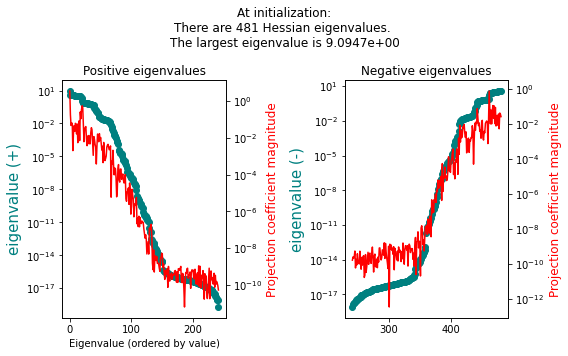

In [9]:
hessian = hessian_autograd(mlp, mse_loss_fn_torch, x_i, y_i)
vals, vs = decompose_hessian(hessian, lenghts, shapes)
mlp.zero_grad()

mse_loss_fn_torch(mlp(x_i), y_i).backward()
g = [p.grad.detach().clone().cpu() for p in mlp.parameters()]
mlp.zero_grad()

positives = [x for x in vals.numpy() if x >= 0]
negatives = [x for x in vals.numpy() if x < 0]
positives.reverse()
negatives.reverse()

pos_dot_prods = [np.abs(dot_prod(g, vs[i])) for i in range(len(vs)) if vals.numpy()[i] >= 0]
neg_dot_prods = [np.abs(dot_prod(g, vs[i])) for i in range(len(vs)) if vals.numpy()[i] < 0]
pos_dot_prods.reverse()
neg_dot_prods.reverse()

plt.figure(figsize=(8, 5))

ax1 = plt.subplot(1, 2, 1)
ax1.scatter(list(range(len(positives))), positives, color='teal')
ax1.set_yscale('log')
ax1.set_title("Positive eigenvalues")
ax1.set_ylabel("eigenvalue (+)", fontsize=15, color='teal')
ax1.set_xlabel("Eigenvalue (ordered by value)")
ax2 = ax1.twinx()
ax2.plot(list(range(len(positives))), pos_dot_prods, color='red')
ax2.set_yscale('log')
ax2.set_ylabel('Projection coefficient magnitude', fontsize=12, color='red')

ax1 = plt.subplot(1, 2, 2)
ax1.scatter(list(range(len(positives), len(positives) + len(negatives))), np.abs(negatives), color='teal')
ax1.set_yscale('log')
ax1.set_title("Negative eigenvalues")
ax1.set_ylabel("eigenvalue (-)", fontsize=15, color='teal')
ax2 = ax1.twinx()
ax2.plot(list(range(len(positives), len(positives) + len(negatives))), neg_dot_prods, color='red')
ax2.set_yscale('log')
ax2.set_ylabel('Projection coefficient magnitude', fontsize=12, color='red')

plt.suptitle("At initialization:\nThere are {0:d} Hessian eigenvalues. \nThe largest eigenvalue is {1:.4e}".format(len(vals), max(positives)))

plt.tight_layout()

In [10]:
result = optimize.minimize(loss,
                       param_vector, 
                       args=(lenghts, shapes, mlp, mse_loss_fn_torch, x_i, y_i, device),
                       jac=gradient,
                       method='BFGS',
                       options={
                           'disp': True,
                           'gtol': 1e-40,
                           'maxiter': 25000,
#                                'finite_diff_rel_step': 1e-15
                       },
                    )

l = 0
for j, param in enumerate(mlp.parameters()):
    param_data = result.x[l:l+lenghts[j]]
    l += lenghts[j]
    param_data_shaped = param_data.reshape(shapes[j])
    param.data = torch.tensor(param_data_shaped).to(device)

l = mse_loss_fn_torch(mlp(x_i), y_i).item()
print(l)
mlp.zero_grad()

         Current function value: 0.000000
         Iterations: 3733
         Function evaluations: 4159
         Gradient evaluations: 4147
1.385593278728062e-13


In [11]:
solution_params = [p.detach().clone() for p in mlp.parameters()]

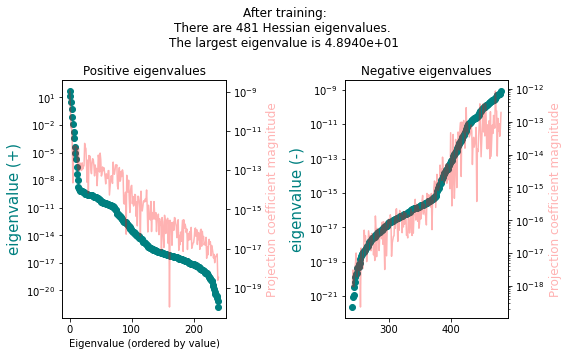

In [12]:
for j, p in enumerate(mlp.parameters()):
    p.data = solution_params[j].clone()

hessian = hessian_autograd(mlp, mse_loss_fn_torch, x_i, y_i)
vals, vs = decompose_hessian(hessian, lenghts, shapes)
mlp.zero_grad()

mse_loss_fn_torch(mlp(x_i), y_i).backward()
g = [p.grad.detach().clone().cpu() for p in mlp.parameters()]
mlp.zero_grad()

positives = [x for x in vals.numpy() if x >= 0]
negatives = [x for x in vals.numpy() if x < 0]
positives.reverse()
negatives.reverse()

pos_dot_prods = [np.abs(dot_prod(g, vs[i])) for i in range(len(vs)) if vals.numpy()[i] >= 0]
neg_dot_prods = [np.abs(dot_prod(g, vs[i])) for i in range(len(vs)) if vals.numpy()[i] < 0]
pos_dot_prods.reverse()
neg_dot_prods.reverse()

plt.figure(figsize=(8, 5))

ax1 = plt.subplot(1, 2, 1)
ax1.scatter(list(range(len(positives))), positives, color='teal')
ax1.set_yscale('log')
ax1.set_title("Positive eigenvalues")
ax1.set_ylabel("eigenvalue (+)", fontsize=15, color='teal')
ax1.set_xlabel("Eigenvalue (ordered by value)")
ax2 = ax1.twinx()
ax2.plot(list(range(len(positives))), pos_dot_prods, color='red', alpha=0.3)
ax2.set_yscale('log')
ax2.set_ylabel('Projection coefficient magnitude', fontsize=12, color='red', alpha=0.3)

ax1 = plt.subplot(1, 2, 2)
ax1.scatter(list(range(len(positives), len(positives) + len(negatives))), np.abs(negatives), color='teal')
ax1.set_yscale('log')
ax1.set_title("Negative eigenvalues")
ax1.set_ylabel("eigenvalue (-)", fontsize=15, color='teal')
ax2 = ax1.twinx()
ax2.plot(list(range(len(positives), len(positives) + len(negatives))), neg_dot_prods, color='red', alpha=0.3)
ax2.set_yscale('log')
ax2.set_ylabel('Projection coefficient magnitude', fontsize=12, color='red', alpha=0.3)

plt.suptitle("After training:\nThere are {0:d} Hessian eigenvalues. \nThe largest eigenvalue is {1:.4e}".format(len(vals), max(positives)))

plt.tight_layout()

## Train in low-curvature subspace

In [ ]:
for j, p in enumerate(mlp.parameters()):
    p.data = solution_params[j].clone()

curvature_threshold = 1e-5
lr = 5e5

losses = []
for _ in tqdm(range(10)):
    
    mse_loss_fn_torch(mlp(x_i), y_i).backward()
    g = [p.grad.detach().clone().cpu() for p in mlp.parameters()]
    mlp.zero_grad()
    with torch.no_grad():
        g_mag = np.sqrt(dot_prod(g, g))
    
    hessian = hessian_autograd(mlp, mse_loss_fn_torch, x_i, y_i)
    vals, vs = decompose_hessian(hessian, lenghts, shapes)
    mlp.zero_grad()
    
    with torch.no_grad():
        for i, p in enumerate(mlp.parameters()):
            g_i_proj = torch.zeros(p.shape).to(device)
            for j, (val, v) in enumerate(zip(vals.numpy(), vs)):
                if np.abs(val) < curvature_threshold:
                    g_i_proj += (v[i] * dot_prod(v, g)).to(device)
            p.add_(-lr * g_i_proj)
        losses.append(mse_loss_fn_torch(mlp(x_i), y_i).item())

In [ ]:
plt.plot(losses)
plt.ylabel("RMSE loss")
plt.xlabel("Curvature-restricted subspace training steps")

In [ ]:
for j, p in enumerate(mlp.parameters()):
    p.data = solution_params[j].clone()

curvature_threshold = 1e-5

mse_loss_fn_torch(mlp(x_i), y_i).backward()
g = [p.grad.detach().clone().cpu() for p in mlp.parameters()]
mlp.zero_grad()
with torch.no_grad():
    g_mag = np.sqrt(dot_prod(g, g))

hessian = hessian_autograd(mlp, mse_loss_fn_torch, x_i, y_i)
vals, vs = decompose_hessian(hessian, lenghts, shapes)
mlp.zero_grad()

v_g = []

with torch.no_grad():
    for i, p in enumerate(mlp.parameters()):
        g_i_proj = torch.zeros(p.shape).to(device)
        for j, (val, v) in enumerate(zip(vals.numpy(), vs)):
            if np.abs(val) < curvature_threshold:
                g_i_proj += (v[i] * dot_prod(v, g)).to(device)
        v_g.append(g_i_proj)
#             p.add_(-lr * g_i_proj)
#         losses.append(mse_loss_fn_torch(mlp(x_i), y_i).item())

In [ ]:
mlp.zero_grad()
losses = []
alphas = np.linspace(-1e7, 1e6, 200)
for alpha in tqdm(alphas):
    with torch.no_grad():
        for j, p in enumerate(mlp.parameters()):
            p.data = solution_params[j].clone() + alpha * v_g[j]
        losses.append(mse_loss_fn_torch(mlp(x_i), y_i).item())

In [ ]:
plt.plot(alphas, losses)
plt.yscale('log')

In [13]:
def logarithmic_line_search(f, low=1e-12, high=1e12, points=15, depth=4):
    """Performs line search of positive parameter between 
    `low` and `high`, minimizing objective function `f`.
    Only searches through positive values of parameter,
    so define your objective function `f` accordingly."""
    assert low > 0 and high > 0
    best_loss = float('inf')
    best_alpha = None
    for d in range(depth):
        alphas = np.exp(np.linspace(np.log(low), np.log(high), points))
        losses = [f(alpha) for alpha in alphas]
        i_min = np.argmin(losses)
        if losses[i_min] < best_loss:
            best_alpha = alphas[i_min]
        else:
            return alphas[i_min]
        if i_min == 0:
            high = alphas[i_min + 1]
            low = alphas[i_min] * (alphas[i_min] / alphas[i_min + 1])
        elif i_min == points - 1:
            low = alphas[i_min - 1]
            high = alphas[i_min] * (alphas[i_min] / alphas[i_min - 1])
        else:
            low = alphas[i_min - 1]
            high = alphas[i_min + 1]
    return best_alpha

### perform low-curvature subspace training with line search

In [16]:
# start training at the end of BFGS
for j, p in enumerate(mlp.parameters()):
    p.data = solution_params[j].clone()

curvature_threshold = 1e-4

lrs = []
losses = []
for _ in tqdm(range(500)):
    
    # parameters we start the step at
    step_params = [p.detach().clone() for p in mlp.parameters()]
    
    # compute gradient and hessian
    l = mse_loss_fn_torch(mlp(x_i), y_i)
    l.backward()
    g = [p.grad.detach().clone().cpu() for p in mlp.parameters()]
    mlp.zero_grad()
    hessian = hessian_autograd(mlp, mse_loss_fn_torch, x_i, y_i)
    vals, vs = decompose_hessian(hessian, lenghts, shapes)
    mlp.zero_grad()
    
    # compute projected gradient
    v_g = []
    with torch.no_grad():
        for i, p in enumerate(mlp.parameters()):
            g_i_proj = torch.zeros(p.shape).to(device)
            for j, (val, v) in enumerate(zip(vals.numpy(), vs)):
                if np.abs(val) < curvature_threshold:
                    g_i_proj += (v[i] * dot_prod(v, g)).to(device)
            v_g.append(g_i_proj)
    
    # helper function for computing loss along direction v_g
    @torch.no_grad()
    def f(alpha):
        for j, p in enumerate(mlp.parameters()):
            p.data = step_params[j].clone() - alpha * v_g[j]
        l = mse_loss_fn_torch(mlp(x_i), y_i).item()
        for j, p in enumerate(mlp.parameters()):
            p.data = step_params[j].clone()
        return l
    
    # perform search and step
    lr = logarithmic_line_search(f)
    with torch.no_grad():
        for i, p in enumerate(mlp.parameters()):
            p.add_(-lr * v_g[i])
    lrs.append(lr)
    losses.append(mse_loss_fn_torch(mlp(x_i), y_i).item())
    if losses[-1] > l.item():
        for j, p in enumerate(mlp.parameters()):
            p.data = step_params[j].clone()
        break

  0%|          | 0/500 [00:00<?, ?it/s]

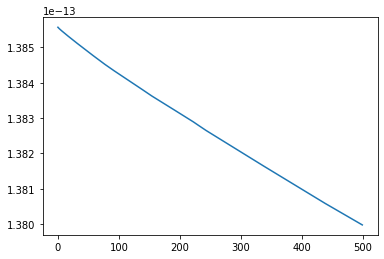

In [17]:
plt.plot(losses)

In [35]:
thresholds = [1e-6, 1e-8, 1e-10, 1e-12, 1e-15]
lrs = defaultdict(list)
losses = defaultdict(list)

for curvature_threshold in tqdm(thresholds):
    # start training at the end of BFGS
    for j, p in enumerate(mlp.parameters()):
        p.data = solution_params[j].clone()

    for _ in tqdm(range(200), leave=False):

        # parameters we start the step at
        step_params = [p.detach().clone() for p in mlp.parameters()]

        # compute gradient and hessian
        l = mse_loss_fn_torch(mlp(x_i), y_i)
        l.backward()
        g = [p.grad.detach().clone().cpu() for p in mlp.parameters()]
        mlp.zero_grad()
        hessian = hessian_autograd(mlp, mse_loss_fn_torch, x_i, y_i)
        vals, vs = decompose_hessian(hessian, lenghts, shapes)
        mlp.zero_grad()

        # compute projected gradient
        v_g = []
        with torch.no_grad():
            for i, p in enumerate(mlp.parameters()):
                g_i_proj = torch.zeros(p.shape).to(device)
                for j, (val, v) in enumerate(zip(vals.numpy(), vs)):
                    if np.abs(val) < curvature_threshold:
                        g_i_proj += (v[i] * dot_prod(v, g)).to(device)
                v_g.append(g_i_proj)

        # helper function for computing loss along direction v_g
        @torch.no_grad()
        def f(alpha):
            for j, p in enumerate(mlp.parameters()):
                p.data = step_params[j].clone() - alpha * v_g[j]
            l = mse_loss_fn_torch(mlp(x_i), y_i).item()
            for j, p in enumerate(mlp.parameters()):
                p.data = step_params[j].clone()
            return l

        # perform search and step
        lr = logarithmic_line_search(f)
        with torch.no_grad():
            for i, p in enumerate(mlp.parameters()):
                p.add_(-lr * v_g[i])
        lrs[curvature_threshold].append(lr)
        losses[curvature_threshold].append(mse_loss_fn_torch(mlp(x_i), y_i).item())
    

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

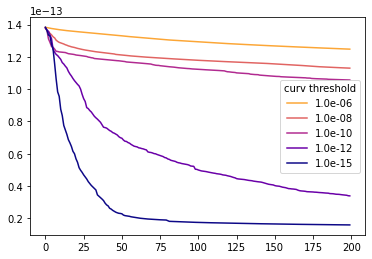

In [44]:
colors = plt.cm.plasma(np.linspace(0.8, 0, len(thresholds)))
for i, curvature_threshold in enumerate(thresholds):
    plt.plot(losses[curvature_threshold], label="{:.1e}".format(curvature_threshold), color=colors[i])
plt.legend(title='curv threshold')

### Redo with a higher upper limit on step size and with even lower thresholds

In [47]:
thresholds = [1e-6, 1e-8, 1e-10, 1e-12, 1e-14, 1e-16, 1e-18]
lrs = defaultdict(list)
losses = defaultdict(list)

for curvature_threshold in tqdm(thresholds):
    # start training at the end of BFGS
    for j, p in enumerate(mlp.parameters()):
        p.data = solution_params[j].clone()

    for _ in tqdm(range(200), leave=False):

        # parameters we start the step at
        step_params = [p.detach().clone() for p in mlp.parameters()]

        # compute gradient and hessian
        l = mse_loss_fn_torch(mlp(x_i), y_i)
        l.backward()
        g = [p.grad.detach().clone().cpu() for p in mlp.parameters()]
        mlp.zero_grad()
        hessian = hessian_autograd(mlp, mse_loss_fn_torch, x_i, y_i)
        vals, vs = decompose_hessian(hessian, lenghts, shapes)
        mlp.zero_grad()

        # compute projected gradient
        v_g = []
        with torch.no_grad():
            for i, p in enumerate(mlp.parameters()):
                g_i_proj = torch.zeros(p.shape).to(device)
                for j, (val, v) in enumerate(zip(vals.numpy(), vs)):
                    if np.abs(val) < curvature_threshold:
                        g_i_proj += (v[i] * dot_prod(v, g)).to(device)
                v_g.append(g_i_proj)

        # helper function for computing loss along direction v_g
        @torch.no_grad()
        def f(alpha):
            for j, p in enumerate(mlp.parameters()):
                p.data = step_params[j].clone() - alpha * v_g[j]
            l = mse_loss_fn_torch(mlp(x_i), y_i).item()
            for j, p in enumerate(mlp.parameters()):
                p.data = step_params[j].clone()
            return l

        # perform search and step
        lr = logarithmic_line_search(f, high=1e18)
        with torch.no_grad():
            for i, p in enumerate(mlp.parameters()):
                p.add_(-lr * v_g[i])
        lrs[curvature_threshold].append(lr)
        losses[curvature_threshold].append(mse_loss_fn_torch(mlp(x_i), y_i).item())
    

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Further reducing loss (after BFGS) with line searches\nin low-curvature subspaces')

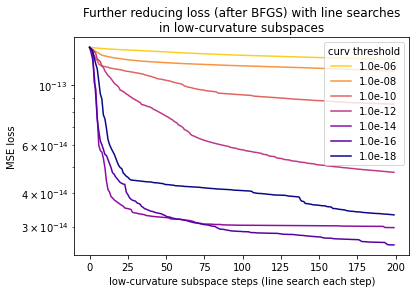

In [55]:
colors = plt.cm.plasma(np.linspace(0.9, 0, len(thresholds)))
for i, curvature_threshold in enumerate(thresholds):
    plt.plot(losses[curvature_threshold], label="{:.1e}".format(curvature_threshold), color=colors[i])
plt.legend(title='curv threshold', loc='upper right')
plt.xlabel('low-curvature subspace steps (line search each step)')
plt.yscale('log')
plt.ylabel('MSE loss')
plt.title("Further reducing loss (after BFGS) with line searches\nin low-curvature subspaces")

In [53]:
losses[1e-16]

[1.3832004542974203e-13,
 1.3198238076315942e-13,
 1.2457245781276357e-13,
 1.0948402154582672e-13,
 9.174110989189353e-14,
 7.471798806498432e-14,
 6.774264216552252e-14,
 6.228717498160969e-14,
 6.032595265086807e-14,
 5.804384066491343e-14,
 5.550951853143313e-14,
 5.5042227682368445e-14,
 5.323723057024406e-14,
 5.139542900805545e-14,
 4.963575170101742e-14,
 4.751792728604941e-14,
 4.6928880579113584e-14,
 4.5860203960331304e-14,
 4.516521313345596e-14,
 4.441231333145881e-14,
 4.3723438290945705e-14,
 4.344417956442921e-14,
 4.3139567561688006e-14,
 4.3040895203386096e-14,
 4.021980274477118e-14,
 3.9461106052978737e-14,
 3.8459171732810595e-14,
 3.794118731727139e-14,
 3.7596877842968357e-14,
 3.746869515100934e-14,
 3.7295820463262704e-14,
 3.674682323264484e-14,
 3.6573618757565866e-14,
 3.633553880238109e-14,
 3.563160825528646e-14,
 3.5399611080033435e-14,
 3.493880036088241e-14,
 3.484936308434888e-14,
 3.460323803131363e-14,
 3.445106520955767e-14,
 3.423759904030992e-14,


## Deprecated (unmodified from clone of another notebook)

In [ ]:
for j, p in enumerate(mlp.parameters()):
    p.data = solution_params[j].clone()

curvature_threshold = 1e-3
lr = 2.5e3

losses = []
for _ in tqdm(range(500)):
    
    rmse_loss_fn_torch(mlp(x_i), y_i).backward()
    g = [p.grad.detach().clone().cpu() for p in mlp.parameters()]
    mlp.zero_grad()
    with torch.no_grad():
        g_mag = np.sqrt(dot_prod(g, g))
    
    hessian = hessian_autograd(mlp, rmse_loss_fn_torch, x_i, y_i)
    vals, vs = decompose_hessian(hessian, lenghts, shapes)
    mlp.zero_grad()
    
    with torch.no_grad():
        for i, p in enumerate(mlp.parameters()):
            g_i_proj = torch.zeros(p.shape).to(device)
            for j, (val, v) in enumerate(zip(vals.numpy(), vs)):
                if np.abs(val) < curvature_threshold:
                    g_i_proj += (v[i] * dot_prod(v, g) / g_mag).to(device)
            p.add_(-lr * g_i_proj)
        losses.append(rmse_loss_fn_torch(mlp(x_i), y_i).item())

In [ ]:
plt.plot(losses)
plt.ylabel("RMSE loss")
plt.xlabel("Curvature-restricted subspace training steps")

In [ ]:
for j, p in enumerate(mlp.parameters()):
    p.data = solution_params[j].clone()

curvature_threshold = 1e-4
lr = 2.5e3

losses = []
for _ in tqdm(range(200)):
    
    rmse_loss_fn_torch(mlp(x_i), y_i).backward()
    g = [p.grad.detach().clone().cpu() for p in mlp.parameters()]
    mlp.zero_grad()
    with torch.no_grad():
        g_mag = np.sqrt(dot_prod(g, g))
    
    hessian = hessian_autograd(mlp, rmse_loss_fn_torch, x_i, y_i)
    vals, vs = decompose_hessian(hessian, lenghts, shapes)
    mlp.zero_grad()
    
    with torch.no_grad():
        for i, p in enumerate(mlp.parameters()):
            g_i_proj = torch.zeros(p.shape).to(device)
            for j, (val, v) in enumerate(zip(vals.numpy(), vs)):
                if np.abs(val) < curvature_threshold:
                    g_i_proj += (v[i] * dot_prod(v, g) / g_mag).to(device)
            p.add_(-lr * g_i_proj)
        losses.append(rmse_loss_fn_torch(mlp(x_i), y_i).item())

In [ ]:
plt.plot(losses)
plt.ylabel("RMSE loss")
plt.xlabel("Curvature-restricted subspace training steps")

In [ ]:
thresholds = [2**(-n) for n in range(15)]
lrs = [2**n for n in range(-4, 20)]

results = dict()

for lr, curvature_threshold in tqdm(list(product(thresholds, lrs))):
    
    for j, p in enumerate(mlp.parameters()):
        p.data = solution_params[j].clone()

    for _ in range(10):

        rmse_loss_fn_torch(mlp(x_i), y_i).backward()
        g = [p.grad.detach().clone().cpu() for p in mlp.parameters()]
        mlp.zero_grad()
        with torch.no_grad():
            g_mag = np.sqrt(dot_prod(g, g))

        hessian = hessian_autograd(mlp, rmse_loss_fn_torch, x_i, y_i)
        vals, vs = decompose_hessian(hessian, lenghts, shapes)
        mlp.zero_grad()
        
        losses = []
        with torch.no_grad():
            for i, p in enumerate(mlp.parameters()):
                g_i_proj = torch.zeros(p.shape).to(device)
                for j, (val, v) in enumerate(zip(vals.numpy(), vs)):
                    if np.abs(val) < curvature_threshold:
                        g_i_proj += (v[i] * dot_prod(v, g) / g_mag).to(device)
                p.add_(-lr * g_i_proj)
            losses.append(rmse_loss_fn_torch(mlp(x_i), y_i).item())
        results[(lr, curvature_threshold)] = min(losses)


In [ ]:
min(results.values())

### Implement Adam within the restricted space

In [ ]:
for j, p in enumerate(mlp.parameters()):
    p.data = solution_params[j].clone()

curvature_threshold = 1e-4
lr = 1.0e-10

beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

m = [torch.zeros(p.shape).to(device) for p in mlp.parameters()]
v = [torch.zeros(p.shape).to(device) for p in mlp.parameters()]

losses = []
for t in tqdm(range(10)):
    with torch.no_grad():
        losses.append(rmse_loss_fn_torch(mlp(x_i), y_i).item())
    
    rmse_loss_fn_torch(mlp(x_i), y_i).backward()
    g = [p.grad.detach().clone().cpu() for p in mlp.parameters()]
    mlp.zero_grad()
    with torch.no_grad():
        g_mag = np.sqrt(dot_prod(g, g))
    
    hessian = hessian_autograd(mlp, rmse_loss_fn_torch, x_i, y_i)
    vals, vs = decompose_hessian(hessian, lenghts, shapes)
    mlp.zero_grad()
    
    g_proj = []
    with torch.no_grad():
        for i, p in enumerate(mlp.parameters()):
            g_i_proj = torch.zeros(p.shape).to(device)
            for j, (val, vec) in enumerate(zip(vals.numpy(), vs)):
                if np.abs(val) < curvature_threshold:
                    g_i_proj += (vec[i] * dot_prod(vec, g) / g_mag).to(device)
            g_proj.append(g_i_proj)
    
    with torch.no_grad():
        for i, p in enumerate(mlp.parameters()):
            m[i] = beta1 * m[i] + (1 - beta1) * g_proj[i]
            v[i] = beta2 * v[i] + (1 - beta2) * torch.pow(g_proj[i], 2)
            mhat = m[i] / (1 + np.power(beta1, t))
            vhat = v[i] / (1 + np.power(beta2, t))
            p.add_(-lr * mhat / (torch.sqrt(vhat) + epsilon))
            
        losses.append(rmse_loss_fn_torch(mlp(x_i), y_i).item())

In [ ]:
plt.plot(losses)
plt.yscale('log')

In [ ]:
for j, p in enumerate(mlp.parameters()):
    p.data = solution_params[j].clone()

curvature_threshold = 1e-4

lrs = []

losses = []
for _ in tqdm(range(10)):
    
    rmse_loss_fn_torch(mlp(x_i), y_i).backward()
    g = [p.grad.detach().clone().cpu() for p in mlp.parameters()]
    mlp.zero_grad()
    with torch.no_grad():
        g_mag = np.sqrt(dot_prod(g, g))
    
    hessian = hessian_autograd(mlp, rmse_loss_fn_torch, x_i, y_i)
    vals, vs = decompose_hessian(hessian, lenghts, shapes)
    mlp.zero_grad()
    
    with torch.no_grad():
        for i, p in enumerate(mlp.parameters()):
            g_i_proj = torch.zeros(p.shape).to(device)
            optimal_lrs = []
            for j, (val, v) in enumerate(zip(vals.numpy(), vs)):
                if np.abs(val) < curvature_threshold:
                    prod = dot_prod(v, g)
                    optimal_lrs.append(np.power(dot_prod(v, g), 2) / g_mag / np.abs(val))
                    g_i_proj += (v[i] * prod / g_mag).to(device)
            lr = np.mean(optimal_lrs)
            lrs.append(lr)
            p.add_(-lr * g_i_proj)
        losses.append(rmse_loss_fn_torch(mlp(x_i), y_i).item())
    

In [ ]:
plt.plot(losses)